In [1]:
from functions0 import *
import numpy as np
import datetime
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
n_steps=99
time=np.pi
initial_state="110" #{"110": 1}
reps = 1
shots = 32000
backend = backend_sim_jakarta
precision=50

In [3]:
numeric_evolution_matrix = eye(8)

for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix(time/n_steps)).evalf(precision)

# here are computed the parameters of the gates as described in "decomposition.ipynb" file.
phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(initial_state=initial_state, U=numeric_evolution_matrix)

M1_qc = fixed_magnetization_two_qubit_gate(phase_1_1,phase_1_2,a1)
M2_qc = fixed_magnetization_two_qubit_gate(phase_2_1,phase_2_2,a2)

metti apposto lo stato iniziale!
6
2


In [4]:
numeric_evolution_matrix.evalf(6)

Matrix([
[1.0 + 5.47686e-15*I,                          0,                         0,                          0,                          0,                         0,                          0,                   0],
[                  0,     0.999997 + 0.0010532*I, 0.000102068 + 0.0010532*I,                          0, -9.87301e-5 - 0.00210639*I,                         0,                          0,                   0],
[                  0,  -9.87301e-5 + 0.0010532*I,   0.999997 - 0.00210639*I,                          0,  0.000102068 + 0.0010532*I,                         0,                          0,                   0],
[                  0,                          0,                         0,     0.999997 + 0.0010532*I,                          0, -9.87301e-5 + 0.0010532*I, 0.000102068 - 0.00210639*I,                   0],
[                  0, 0.000102068 - 0.00210639*I, -9.87301e-5 + 0.0010532*I,                          0,     0.999997 + 0.0010532*I,                   

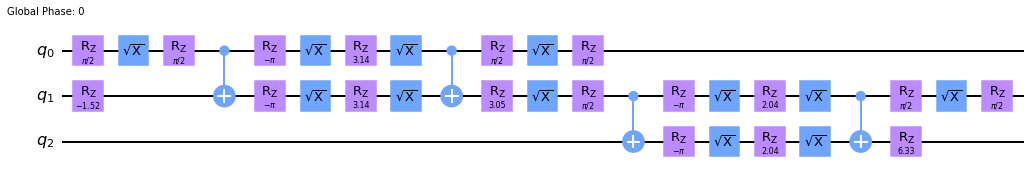

In [5]:
qr3 = QuantumRegister(3 ,name="q")
qc3 = QuantumCircuit(qr3, name="U")

qc3.append(M1_qc, [qr3[0],qr3[1]])
qc3.append(M2_qc, [qr3[1],qr3[2]])

qc3=transpile(qc3, basis_gates=["cx","rz","x","sx"])
qc3.draw(output="mpl")

In [6]:
backend_ = Aer.get_backend('unitary_simulator')
job = execute(qc3, backend_, shots=32000)
result = job.result()
A=result.get_unitary(qc3, decimals=10)
Matrix(A)

Matrix([
[0.9999994454 - 0.0010532002*I,                             0,                              0,                             0,                              0,                              0,                             0,                             0],
[                            0, 0.9999966622 - 0.0010531973*I, -0.0001141886 + 0.0023565333*I,                             0,                              0,                              0,                             0,                             0],
[                            0,   9.87301e-5 + 0.0010531973*I,  0.4479247771 - 0.0197207618*I,                             0, -0.8938526055 + 0.0009414063*I,                              0,                             0,                             0],
[                            0,                             0,                              0, 0.4479260237 - 0.0197208167*I,                              0, -0.8938501178 + 0.0009414037*I, 0.0001020679 - 0.0021063946*I,            

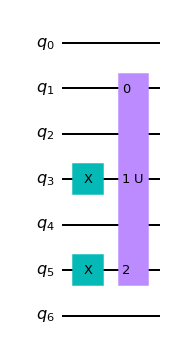

In [7]:
qr = QuantumRegister(7 ,name="q")
qc = QuantumCircuit(qr, name="U")


l=0
for k in [5,3,1]:
    if initial_state[l]=='1':
        qc.x(qr[k])
    l+=1

qc.append(qc3, [qr[1],qr[3],qr[5]])

qc.draw(output="mpl")

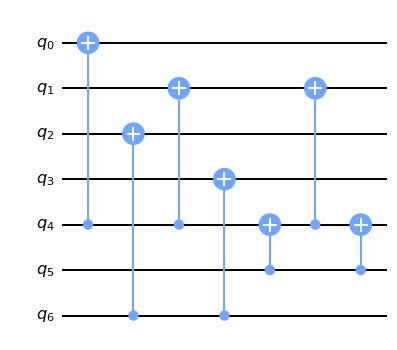

In [8]:
qc_check=symmetry_check(type="4copy_check")
qc_check.draw(output="mpl")

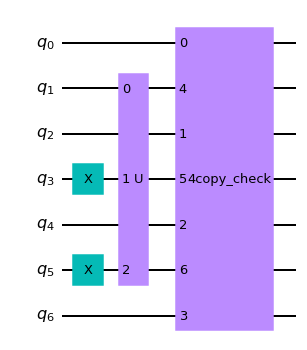

In [9]:
qc=add_symmetry_check(qc, [qr[1],qr[3],qr[5]], [qr[0],qr[2],qr[4],qr[6]], type="4copy_check")
qc.draw(output="mpl")

In [10]:
qcs_tomo = state_tomography_circuits(qc, [qr[1],qr[3],qr[5]])

for qc_iter in qcs_tomo:
    qc_iter.barrier()
    cr_anc=ClassicalRegister(4)
    qc_iter.add_register(cr_anc)
    qc_iter.measure([qr[0],qr[2],qr[4],qr[6]], cr_anc)

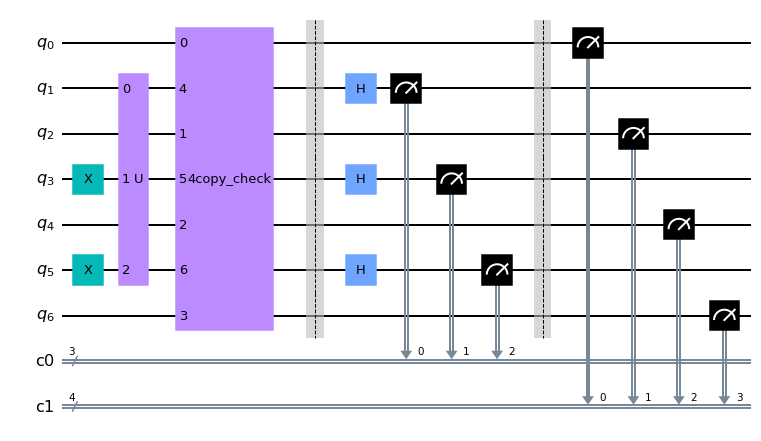

In [11]:
qcs_tomo[0].draw(output="mpl")

In [12]:
qcs_calibs, meas_calibs = calibration_cirquits("itself", q_anc=[0,2,4,6], N=n_steps, time=time, check="yes", check_type="4copy_check")
state_lables = bin_list(7)

cambiare initial_state e time
metti apposto lo stato iniziale!
6
2


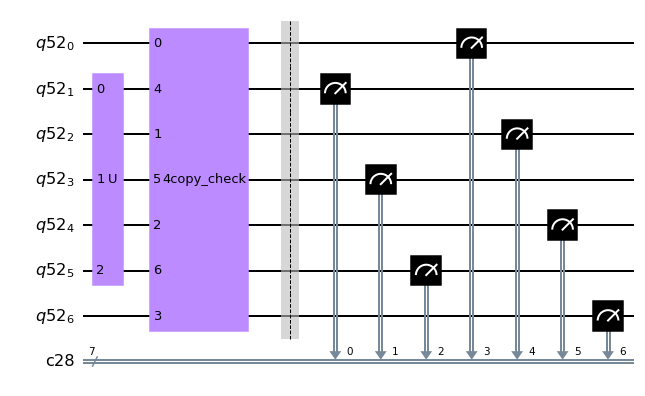

In [13]:
qcs_calibs[0].draw(output="mpl")

In [14]:
jobs_evo=execute(qcs_tomo, backend=backend_real_jakarta, shots=shots)
job_cal_our=execute(qcs_calibs, backend=backend_real_jakarta, shots=shots)
job_cal=execute(meas_calibs, backend=backend_real_jakarta, shots=shots)

# da qui in poi non ti fidare di niente

In [ ]:
meas_fitter_our = CompleteMeasFitter(job_cal_our.result(), state_labels=state_lables)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels=state_lables)

U_tilde=meas_fitter_our.cal_matrix

In [ ]:
qr_basi = QuantumRegister(7)
qc_basi = QuantumCircuit(qr_basi)

#qc_basi.swap(5,4)
#qc_basi.swap(5,2)
#qc_basi.swap(1,3)
#qc_basi.swap(0,1)

qcs_basi = state_tomography_circuits(qc_basi,[0,1,2])


C_matrices = []
C=U_tilde @ np.asarray(np.matrix(U).getH())

for qca in qcs_basi:
    
    qca.remove_final_measurements()

    #qca.swap(0,1)
    #qca.swap(1,3)
    #qca.swap(5,2)
    #qca.swap(5,4)

    qca_matrix = np.matrix(matrix_from_cirquit(qca, type="numpy"))
    qca_matrixH = np.asarray(qca_matrix.getH())

    C_aus = qca_matrix @ (C @ qca_matrixH)

    C_matrices.append(np.asarray(C_aus))

In [ ]:
from copy import deepcopy
meas_fitter_ours = []

for C_new in C_matrices:
    meas_fitter_our_aus = deepcopy(meas_fitter_our)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitter_ours.append(meas_fitter_our_aus)



In [ ]:
reps=1

target_state = (One^One^Zero).to_matrix()

fids=np.zeros([reps,4])
fids_mean=np.zeros(4)
fids_dev=np.zeros(4)

for j in range(reps):
    
    #res = jobs_evo_result[j]
    res=job.result()

    print(j)
    
    new_res, new_res_nm = mitigate2(res, ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter)
    new_res_our, new_res_nm = mitigate2(res, ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_ours)
    new_res_not_mitigated = mitigate2(res, ancillas_conditions=bin_list(4))

    fids[j,0] = fidelity_count(new_res_not_mitigated, qc3, target_state)
    fids[j,1] = fidelity_count(new_res_nm, qc3, target_state)
    fids[j,2] = fidelity_count(new_res, qc3, target_state)
    fids[j,3] = fidelity_count(new_res_our, qc3, target_state)

for i in range(4):
    fids_mean[i]=np.mean(fids[:,i])
    fids_dev[i]=np.std(fids[:,i])

0


QiskitError: 'No counts for experiment "0"'